# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%cd "/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets"
!chmod u+r+x get_datasets.sh
!./get_datasets.sh

/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
--2020-07-03 20:47:33--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2020-07-03 20:47:33 ERROR 500: Internal Server Error.

tar (child): cifar-10-python.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
rm: cannot remove 'cifar-10-python.tar.gz': No such file or directory


In [1]:
!pip install scipy==1.2.1
!pip install pillow==6.1.0

In [3]:
%cd "/content/drive/My Drive/cs231n/assignments/assignment1"

/content/drive/My Drive/cs231n/assignments/assignment1


In [4]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.410866
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ The expected value of the inputs and weights is 0. This means the expected value of all the scores is 0. The expected value of the sum of the exponentiated scores will be C. The numerator will be 1. So the expected value for the loss is -log(1/C). With C being 10 in this case.



In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.303929 analytic: 0.303929, relative error: 1.822331e-08
numerical: -4.583422 analytic: -4.583422, relative error: 2.145705e-09
numerical: 2.380415 analytic: 2.380415, relative error: 1.339620e-08
numerical: 1.425439 analytic: 1.425439, relative error: 1.847828e-08
numerical: 1.252345 analytic: 1.252345, relative error: 3.455450e-08
numerical: -1.492271 analytic: -1.492271, relative error: 1.311922e-08
numerical: 1.970536 analytic: 1.970536, relative error: 3.676114e-10
numerical: 1.118046 analytic: 1.118046, relative error: 4.089718e-08
numerical: 1.479774 analytic: 1.479774, relative error: 2.522752e-08
numerical: 0.480330 analytic: 0.480330, relative error: 7.823036e-08
numerical: 1.084255 analytic: 1.084255, relative error: 5.283364e-08
numerical: -5.620119 analytic: -5.620119, relative error: 4.496361e-09
numerical: 1.737545 analytic: 1.737545, relative error: 2.779929e-08
numerical: -0.970112 analytic: -0.970112, relative error: 4.908035e-08
numerical: 1.240087 analyt

In [8]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.410866e+00 computed in 0.122490s
vectorized loss: 2.410866e+00 computed in 0.015553s
Loss difference: 0.000000
Gradient difference: 0.000000


In [11]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

log_learning_rates = np.repeat([-6.9, -7, -7.1, -6.7, -6.8], 5)+np.random.randn(25)/40
log_reg_strengths = np.tile([4.2, 4.5, 4.3, 4.1, 4.0], 5)+np.random.randn(25)/40
learning_rates = np.exp(np.log(10)*log_learning_rates)
regularization_strengths = np.exp(np.log(10)*log_reg_strengths)

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for eta, reg in zip(learning_rates, regularization_strengths):
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=eta, reg=reg,
                      num_iters=1000, verbose=True)
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)

    train_accuracy = np.mean(y_train_pred == y_train)
    val_accuracy = np.mean(y_val_pred == y_val)

    results[(eta, reg)] = (train_accuracy, val_accuracy)

    if val_accuracy > best_val:
      best_val = val_accuracy
      best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 509.780217
iteration 100 / 1000: loss 233.987888
iteration 200 / 1000: loss 108.596052
iteration 300 / 1000: loss 50.970020
iteration 400 / 1000: loss 24.552945
iteration 500 / 1000: loss 12.391067
iteration 600 / 1000: loss 6.784648
iteration 700 / 1000: loss 4.231550
iteration 800 / 1000: loss 3.065111
iteration 900 / 1000: loss 2.469266
iteration 0 / 1000: loss 926.256839
iteration 100 / 1000: loss 194.966368
iteration 200 / 1000: loss 42.433065
iteration 300 / 1000: loss 10.498386
iteration 400 / 1000: loss 3.872565
iteration 500 / 1000: loss 2.475137
iteration 600 / 1000: loss 2.164178
iteration 700 / 1000: loss 2.149754
iteration 800 / 1000: loss 2.131816
iteration 900 / 1000: loss 2.114966
iteration 0 / 1000: loss 608.202353
iteration 100 / 1000: loss 225.376186
iteration 200 / 1000: loss 84.627898
iteration 300 / 1000: loss 32.533722
iteration 400 / 1000: loss 13.343480
iteration 500 / 1000: loss 6.254584
iteration 600 / 1000: loss 3.615131
iteration 70

In [12]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.363000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ True


$\color{blue}{\textit Your Explanation:}$ As long as the new datapoint's value is not within the margin of the highest class value, the value of the new class will not affect the overall loss. In the softmax classifier loss, however, the value for the new class will affect the result everytime except in the limit of -inf. 



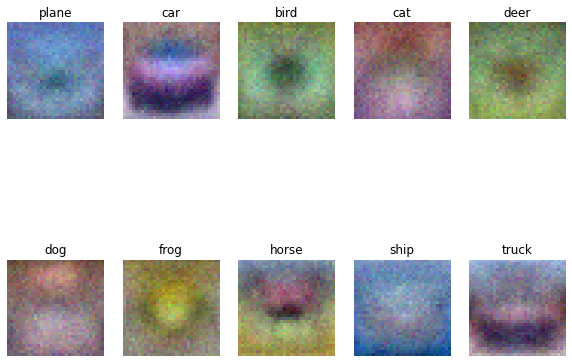

In [13]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])